# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=2000)

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 4526, 'TN': 5448, 'FP': 4595, 'FN': 5431, 'Accuracy': 0.4987, 'Precision': 0.49621752000877095, 'Recall': 0.45455458471427135, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9957, 'TN': 10043, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9957, 'TN': 10043, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9550, 'TN': 9876, 'FP': 167, 'FN': 407, 'Accuracy': 0.9713, 'Precision': 0.9828136256046105, 'Recall': 0.9591242342070905, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9957, 'TN': 10043, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

class sklearn.linear_model.RidgeClassifier(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, class_weight=None, solver='auto', random_state=None)

alpha reduces variance, fit_intercept calc the intercept(?), normalize will normalize before regression, copy_x, max_iter number of iterations, tol is the precision of the solution, class weight will change the weights of classes, solver uses different algorithms in computational routines.

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=.3, tol=0.05, class_weight='balanced', solver='sag')
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9854, 'TN': 9924, 'FP': 119, 'FN': 103, 'Accuracy': 0.9889, 'Precision': 0.9880677830141382, 'Recall': 0.9896555187305414, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=50, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 9957, 'Neg': 10043, 'TP': 9734, 'TN': 9619, 'FP': 424, 'FN': 223, 'Accuracy': 0.96765, 'Precision': 0.9582594999015555, 'Recall': 0.9776036958923371, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

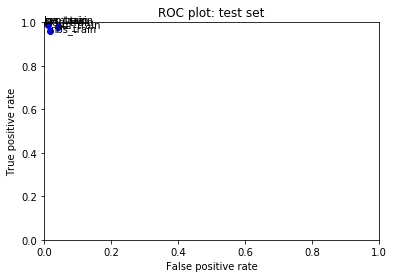

In [12]:
fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [13]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
13
The lovely Eva Longoria Parker plays Kate, who dies after an ice angel crushes her before the \I do's\" with fiancé Henry(Paul Rudd). After two years Henry has yet to move on and his sister Chloe(Lindsay Sloane)is very concerned. Chloe arranges for Henry to talk with an attractive psychic Ashley(Lake Bell). Ashley is to contact Kate's spirit hoping to help Henry get on with his life. When the psychic starts getting attracted to Henry, Kate's ghost appears to nip the romance in the bud. There are some funny situations; but if you've seen the trailers you have seen the substance of the film. Also in the cast: Stephen Root, Jason Biggs, William Morgan Sheppard and Wendi McLendon-Covey. I personally thought that Bell stole the show from Parker. And Biggs as usual a pain in the butt. Still this movie was over-hyped."
* * * * * * * * * 
41
This film was slow but tedious and the acting often drifted into the land of ham. Redgrave's character was unappealing as 

3725
I've just visited Russian forum of our TV-channel that had showed this film. Well... 99 per cent of active Russian audience is disappointed. We wanted to see more true facts of our space achievements in this film. But authors had in mind something else... :( We are big and beautiful country with intelligent people living here. We are proud of all our space dreams, real achievements on the one hand in this field and in science on the other hand. So I'd like to ask authors: Where is our LUNOHOD? And where, the Hell our MIR station? Ah? I'm quite sure, that LUNOHOD events took place much earlier Armstrong's \walk on Moon\". And to comment numerous technical and science mistakes - I really have no time and enough space here! Se our constructive critics in Russian forum on www.1tv.ru"
* * * * * * * * * 
3750
This movie was physically painful to sit through, maybe because (like many people my age, and younger) I grew up with Dr. Seuss and loved his books - funny, clever, whimsical and s

7894
Stewart Kane (Gabriel Byrne, VANITY FAIR) heads out with his local Jindabyne, Australia fishing buddies for a weekend of rest, recreation, and relaxation. But when Stewart discovers an aboriginal woman's body floating face-down in a river, things appear to have turned out for the worst. The largest casualty of the weekend is the men's commonsense. They don't hike out of the ravine, and instead finish their fishing weekend with some great catches. Then they head out and report the body.<br /><br />The town and the men's lives quickly turn into a mess. The local media swarms them, and accusations of aboriginal prejudices rear up from the local natives. Stewart's wife Claire (Laura Linney, THE EXORCISM OF EMILY ROSE) senses the deeper meanings of what her husband and his friends did, but has to battle with it through her own mental illness.<br /><br />Amidst all this chaos is the life that was this young woman who is now a media spectacle, splayed out on a morgue slab. Her murder and

11918
Although the director tried(the filming was made in Tynisia and Morocco),this attempt to transport the New Testament in the screen failed.The script has serious inaccuracies and fantasies,while the duration is very long.But the most tragic is the protagonist Chris Sarandon,who doesn't seem to understand the demands of his role.
* * * * * * * * * 
12060
The movie seemed to appeal me because of the new type of Pokemon Celebi. But the plot was out of course and didn't have as an interest as the other movies. It was a waste of money and time. The same corny humor and cliche bad guys. The movie was of no use to make if you wanted to make Pokemon famous. The movie should better not associated with animes such as Dragonballz, Digimon, or Yu-Gi-Oh. The drawing and settings are of no level rising to the standards of original anime. It is a shame even to talk about this movie. I bet Pokemon fans will be disappointed with the outcome of the movie and give up on Pokemon. Digimon is more of a

17376
Don't even bother with this movie, it's bad when judged on it's own merits, but when compared to the 1972 original (which IS a classic) it's down right awful. And BTW, somebody commented that the 1972 movie is bad when compared to the book. This is silly, movies should never be judged against the books they are taken from. They are 2 completely different art forms (as if this needed to be pointed out but apparently it does). If you used this criteria for all movies then \2001\" would suck and so would \"Forest Gump\" and \"Silence of the Lambs\"."
* * * * * * * * * 
17385
Just utter trash. I'm a huge fan of the Cusacks, this being the sole reason I watched this movie, but the only reason I can see for their presence was the reprise, in complete and depth less quality, their exact roles from Grosse Point Blanc. Apart from that, the films' role as a political satire fails miserably as being too obvious for even the most moronic out there to serve any purpose. And to bill it as a sa

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1041, 'TN': 1372, 'FP': 1085, 'FN': 1502, 'Accuracy': 0.4826, 'Precision': 0.4896519285042333, 'Recall': 0.4093590247738891, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2130, 'TN': 2040, 'FP': 417, 'FN': 413, 'Accuracy': 0.834, 'Precision': 0.8362779740871613, 'Recall': 0.8375933936295714, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2142, 'TN': 2042, 'FP': 415, 'FN': 401, 'Accuracy': 0.8368, 'Precision': 0.8377004301916308, 'Recall': 0.8423122296500196, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1913, 'TN': 1834, 'FP': 623, 'FN': 630, 'Accuracy': 0.7494, 'Precision': 0.7543375394321766, 'Recall': 0.7522611089264648, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2149, 'TN': 2056, 'FP': 401, 'FN': 394, 'Accuracy': 0.841, 'Precision': 0.8427450980392157, 'Recall': 0.8450648839952811, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2308, 'TN': 2177, 'FP': 280, 'FN': 235, 'Accuracy': 0.897, 'Precision': 0.8918083462132921, 'Recall': 0.907589461266221, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1885, 'TN': 1796, 'FP': 661, 'FN': 658, 'Accuracy': 0.7362, 'Precision': 0.7403770620581304, 'Recall': 0.7412504915454188, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

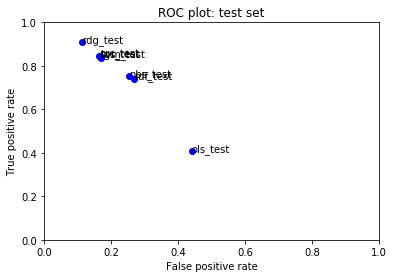

In [22]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [ ]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=200, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...


---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [ ]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

In [ ]:
raw_data.head()

In [ ]:
my_submission.head()

In [ ]:
my_submission.shape

In [ ]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation